In [3]:
library(dplyr)
library(tidyr)
library(jsonlite)
library(ggplot2)
library(data.table)

# Main simulation results

In [3]:
# Simulation setting for methods comparison
Ms = c(20000, 50000, 100000)
Ms = sapply(Ms, function(x) format(x, scientific=F))
Ms = factor(Ms, levels=Ms, labels=Ms)
Mlabel = sapply(Ms, function(x) sprintf('M: %s', x))
Ds = c(50, 100)
Ds = factor(Ds, levels=Ds, labels=Ds)
Ds = sapply(Ds, function(x) format(x, scientific=F))
Dlabel = sapply(Ds, function(x) sprintf('D: %s', x))
K = 5
v = 0.1
Func_names = c("Func_A", "Func_B", "Func_C", "Func_D", "Func_E")
nrep = 50
case = '1'
module = 'emxgb'
gam = 0
lam = 0

In [11]:
# Methods
methods = c('BH', '2G-Zval', '2G-Pval', 'LSMM', 'AdaFDR-depth1', 'AdaFDR-depth2')
labels = setNames(c('BH', 'TGM-Zval', 'TGM-Pval', 'LSMM', 'PALM-Tree1', 'PALM-Tree2'), methods)
labels = factor(labels, levels=labels, labels=labels)
dat = expand_grid(M=Ms, D=Ds, Func=gsub('Func_', '', Func_names), rep=1:nrep, method=methods, FDR=NA, power=NA, pAUC=NA, AUC=NA)

In [15]:
# Retrieve performance of each method
for(M in Ms){
  for(D in Ds){
      
    message(sprintf('M = %s, D = %s', M, D))
      
    res_dir = sprintf('/home/xyubl/Thesis/xgb_simu_results/comp_M%s_D%s_K%s/', M, D, K)
    alt_dir = sprintf('/home/xyubl/Thesis/simu_check_results/comp_M%s_D%s_K%s/', M, D, K)
    
    for(Func_name in Func_names){
      for(r in 1:nrep){
        for(m in methods){
          # load performance
          if(m == '2G-Pval'){
            filename = sprintf('%sperf_%s_%s-case%s-r%s.json', res_dir, m, Func_name, case, r)
            if(file.exists(filename)){
              perf = fromJSON(filename)
            }else{
              perf = list(FDR=NA, power=NA, pAUC=NA, AUC=NA)
            }
          }else if(m == 'AdaFDR-depth1' | m == 'AdaFDR-depth2'){
            J = sub('AdaFDR-depth', '', m)
            filename = sprintf('%sperf_%s-case%s-J%s-v%s-r%s-%s-gam%s-lam%s.json', res_dir, Func_name, case, J, v, r, module, gam, lam)
            if(file.exists(filename)){
              perf = fromJSON(filename)
            }else{
              perf = list(FDR=NA, power=NA, pAUC=NA, AUC=NA)
            }
          }else if(m == 'BH' | m == 'LSMM'){
            filename = sprintf('%sperf_%s_%s-case%s-r%s.RDS', res_dir, m, Func_name, case, r)
            perf = readRDS(file=filename)
          }else{
            filename = sprintf('%sperf_%s-theor_%s-case%s-r%s.RDS', alt_dir, m, Func_name, case, r)
            perf = readRDS(file=filename)
          }
          
          Func_id = sub('Func_', '', Func_name)
          dat <- dat %>% mutate(FDR=ifelse(M==M & D==D & Func==Func_id & method==m & rep==r, perf$FDR, FDR),
                         power=ifelse(M==M & D==D & Func==Func_id & method==m & rep==r, perf$power, power),
                         pAUC=ifelse(M==M & D==D & Func==Func_id & method==m & rep==r, perf$pAUC, pAUC),
                         AUC=ifelse(M==M & D==D & Func==Func_id & method==m & rep==r, perf$AUC, AUC))
          
        }
      }
    }
  }
}

M = 20000, D = 50

M = 20000, D = 100

M = 50000, D = 50

M = 50000, D = 100

M = 100000, D = 50

M = 100000, D = 100



In [16]:
# Boxplot grid
Mlabels = setNames(paste0('M=', Ms), Ms)
Dlabels = setNames(paste0('D=', Ds), Ds)
dat <- dat %>% mutate(Mlab=Mlabels[M], Dlab=Dlabels[D], label=labels[method])

boxplot_grid = function(g, value){
  g = g + geom_boxplot(outlier.shape=NA) +
    facet_grid(Dlab ~ Mlab) + 
    scale_fill_brewer(palette='Set1') +
    xlab('Function') + ylab(value) +
    guides(fill=guide_legend(title="Method", title.position = 'left', nrow=2)) +
    theme(plot.title=element_text(hjust=0.5, size=18),
          strip.text.x = element_text(size=18),
          strip.text.y = element_text(size=18, angle=270),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.position = 'bottom',
          legend.title=element_text(size=14),
          legend.text=element_text(size=14)) 
  return(g)
}

## Performance comparison

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

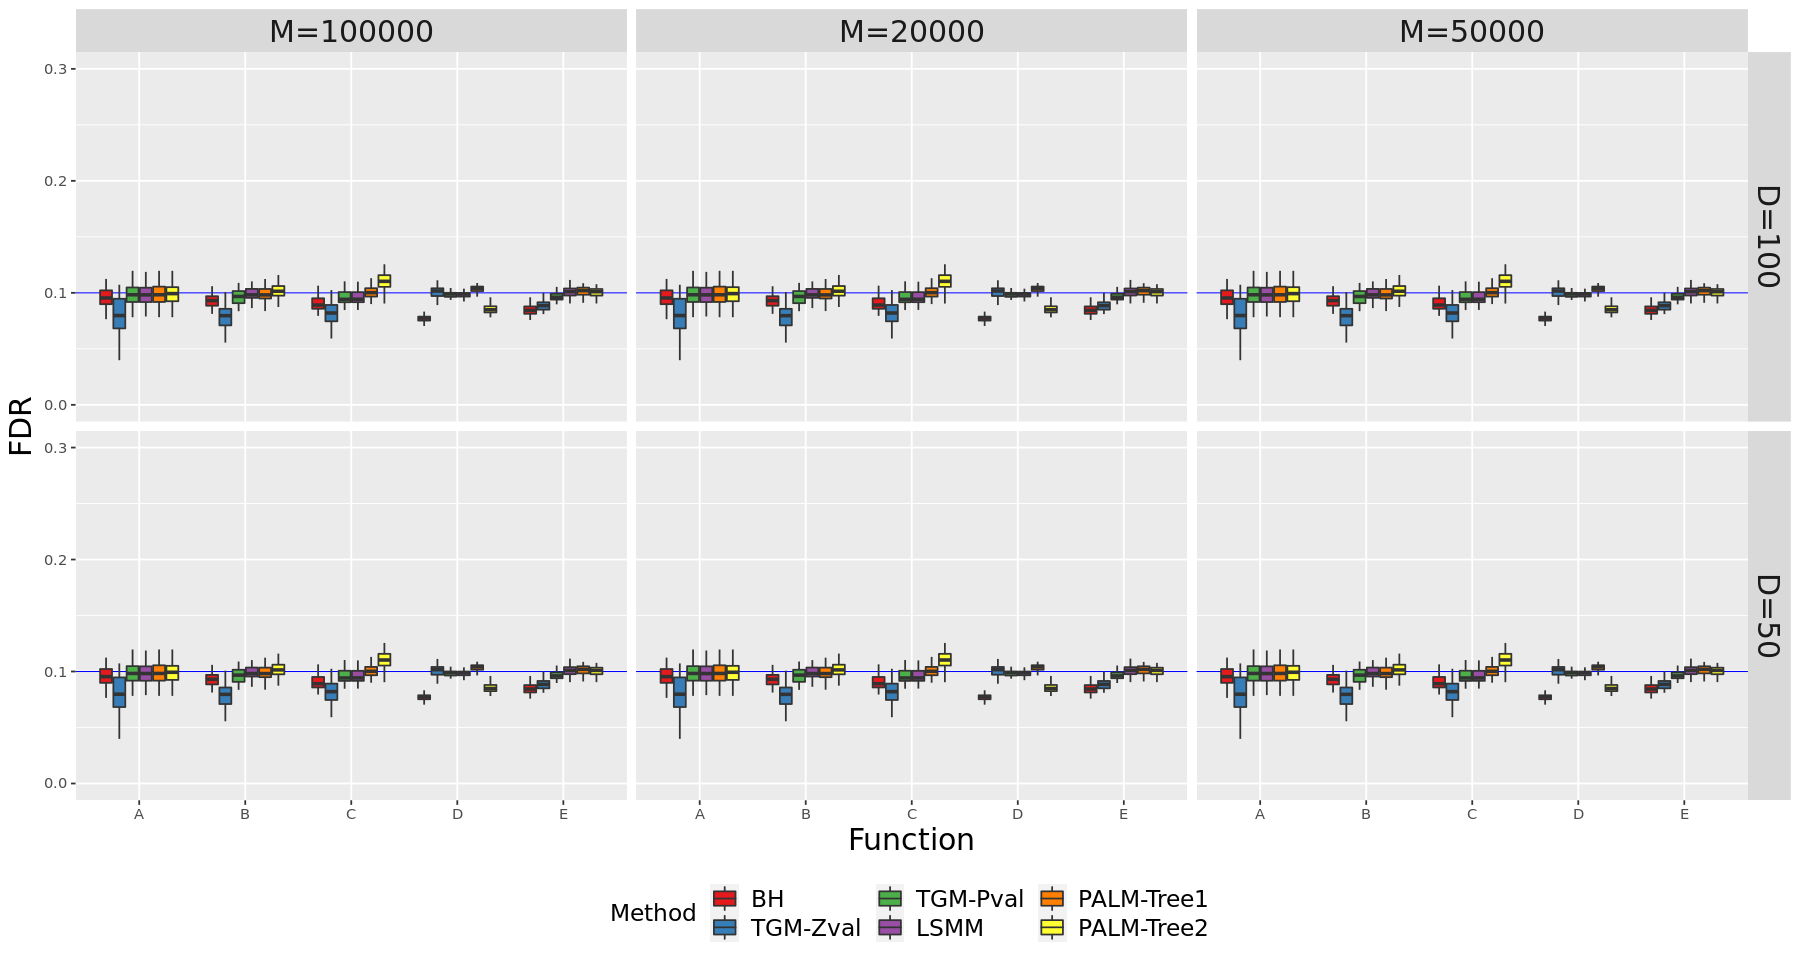

In [19]:
# FDR
g = ggplot(dat, aes(x=Func, y=FDR, fill=label)) +
  geom_hline(yintercept=0.1, lty='solid', size=0.3, color='blue') +
  coord_cartesian(ylim=c(0, 0.3))
boxplot_grid(g, 'FDR')

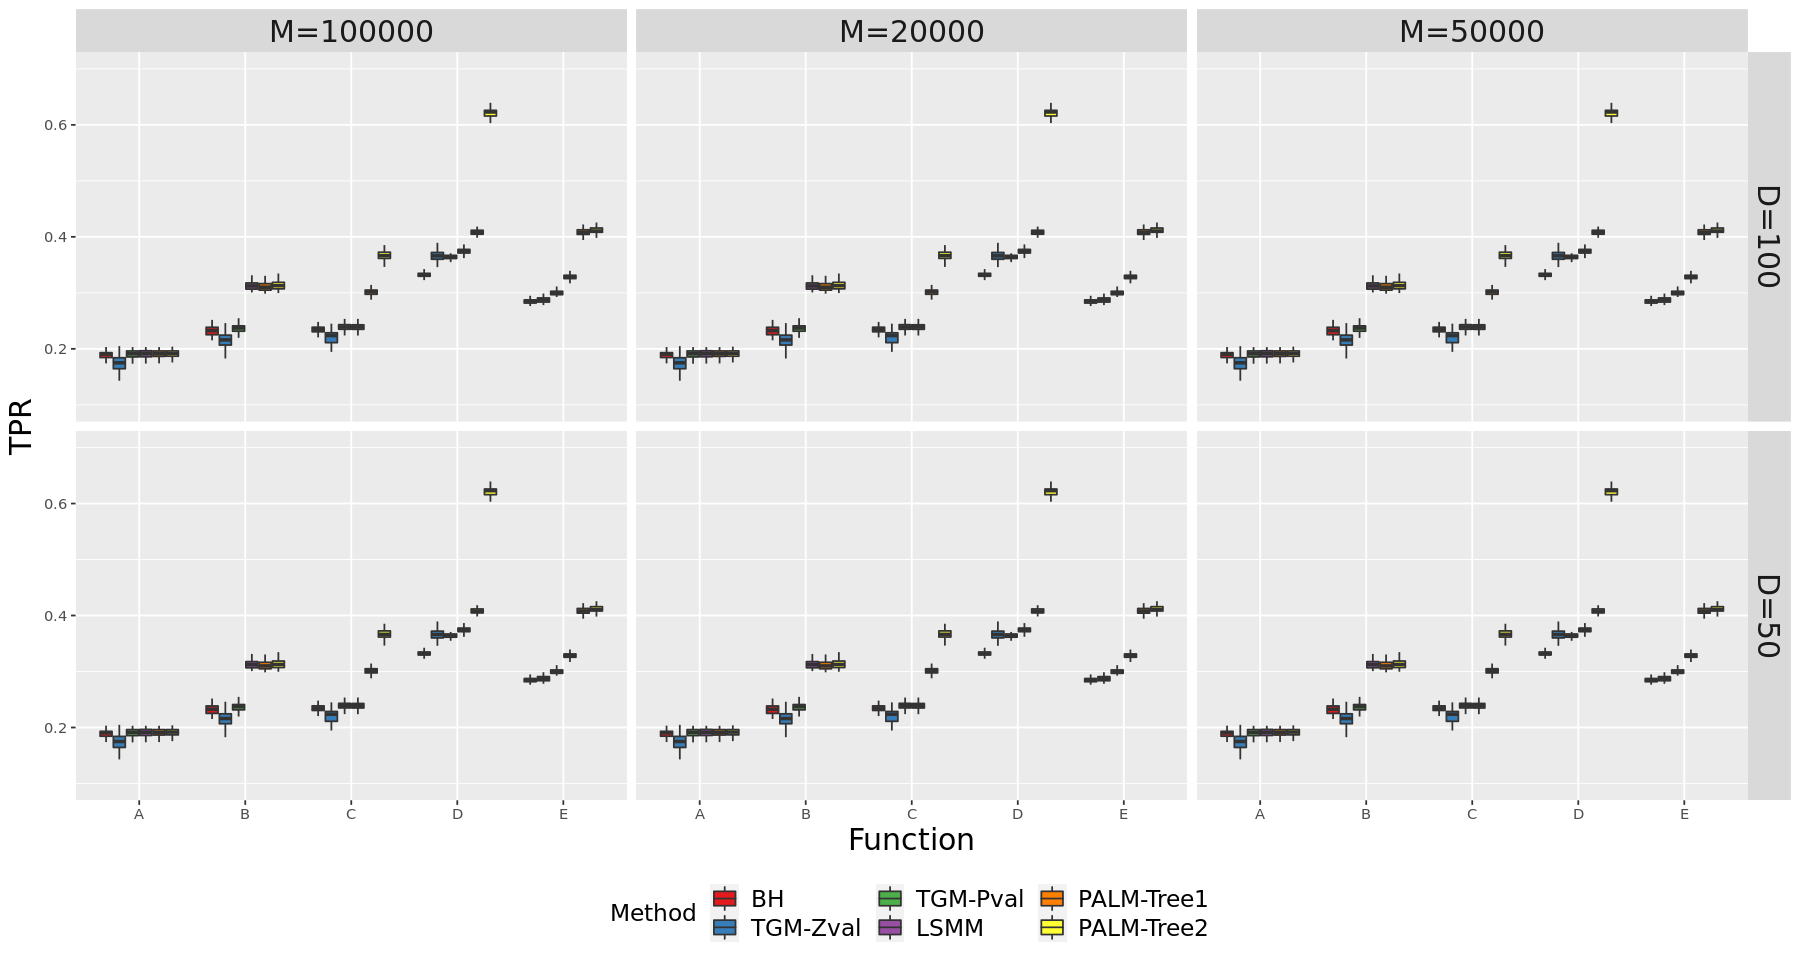

In [21]:
# power
g = ggplot(dat, aes(x=Func, y=power, fill=label)) +
  coord_cartesian(ylim=c(0.1, 0.7)) 
boxplot_grid(g, 'TPR')

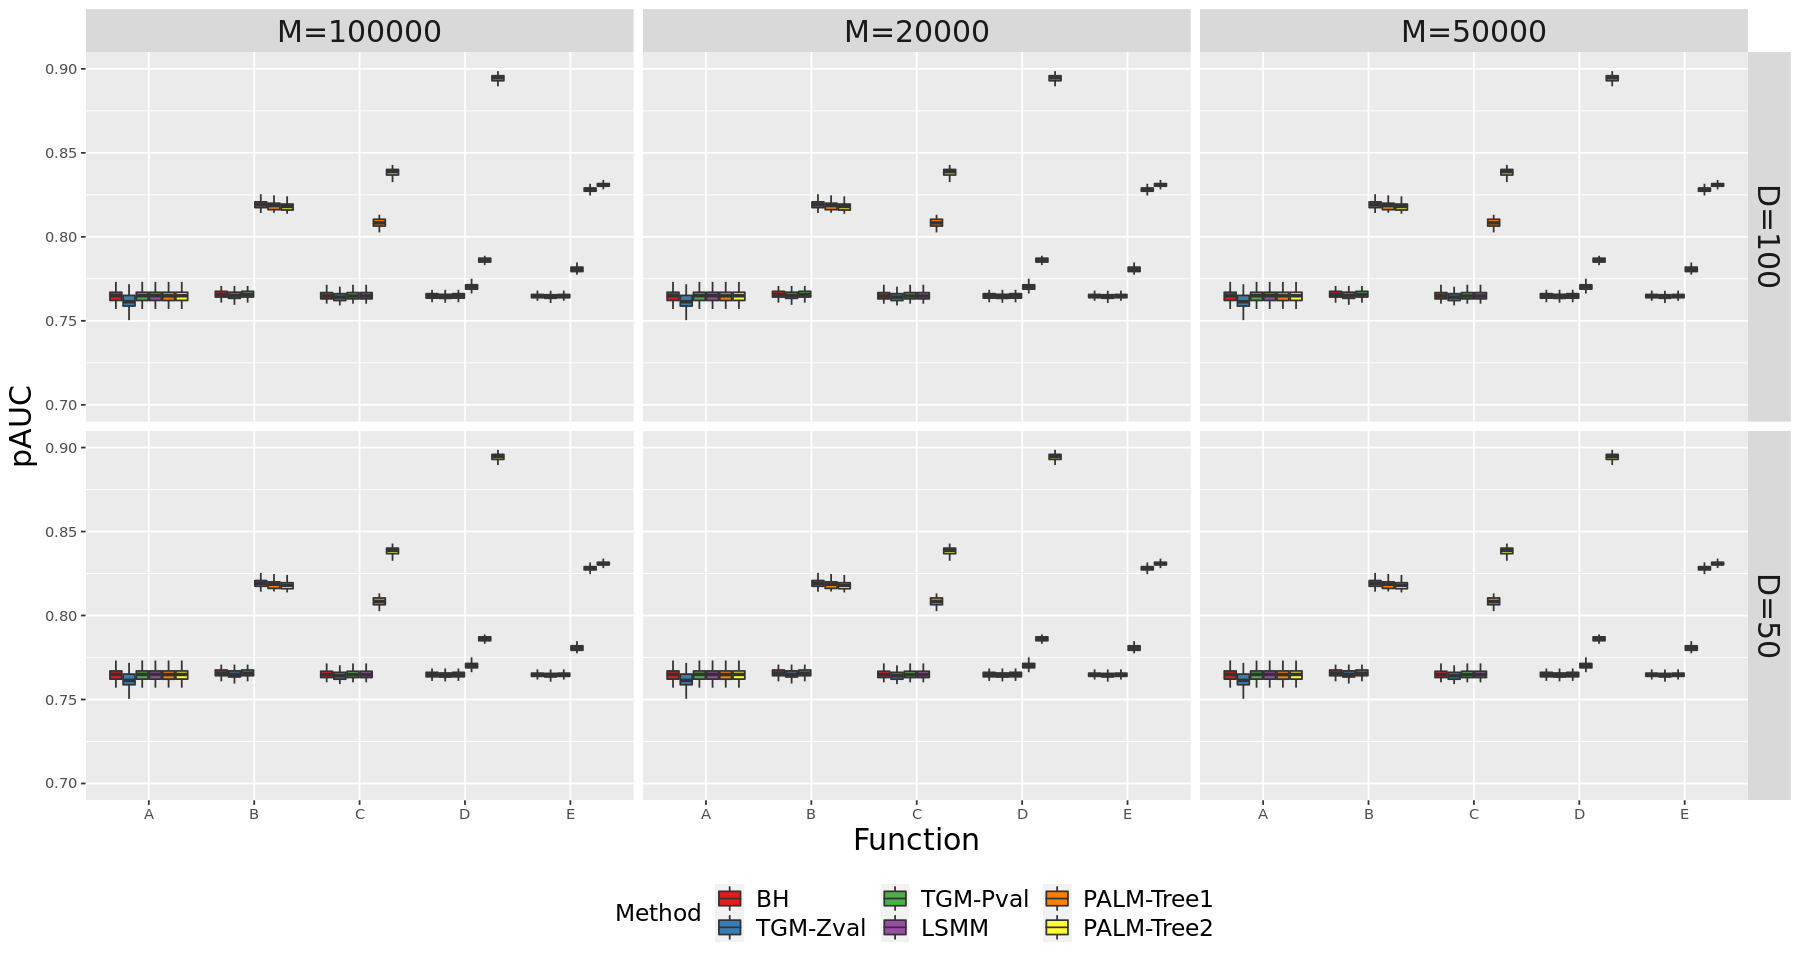

In [22]:
# pAUC
g = ggplot(dat, aes(x=Func, y=pAUC, fill=label)) +
  coord_cartesian(ylim=c(0.7, 0.9))
boxplot_grid(g, 'pAUC')

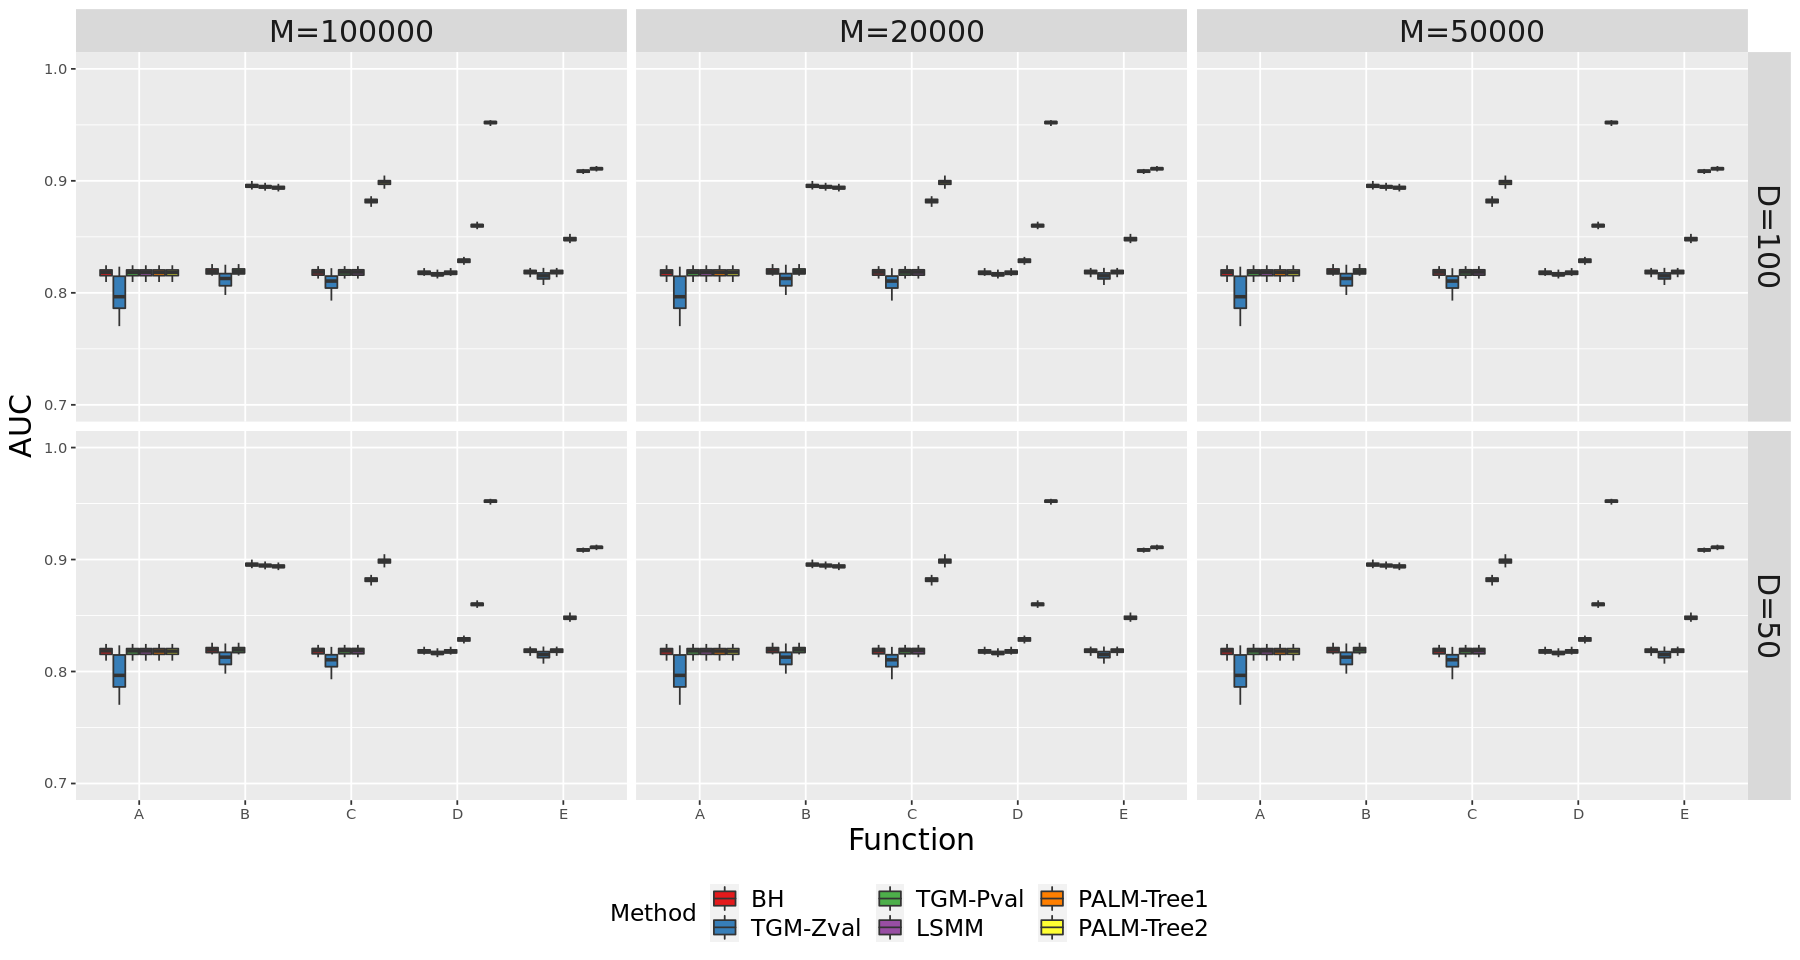

In [23]:
# AUC
g = ggplot(dat, aes(x=Func, y=AUC, fill=label)) +
  coord_cartesian(ylim=c(0.7, 1.0))
boxplot_grid(g, 'AUC')

## Variable importance evaluation by PALM

In [7]:
options(repr.plot.width=15, repr.plot.height=10)

In [5]:
# Variable importance plot
plot_imp_grid = function(g){
  g = g +
    geom_boxplot() + facet_grid(Mlab ~ Func) +
    coord_cartesian(ylim=c(0.0, 1.0)) +
    xlab('Covariate') + ylab('Importance') +
    scale_fill_manual(values = colors) +
    guides(fill=guide_legend(title="Method", title.position = 'left', nrow=1)) +
    theme(strip.text.x = element_text(size=18),
          strip.text.y = element_text(size=18),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.position = 'bottom',
          legend.title=element_text(size=18),
          legend.text=element_text(size=18)) 
  return(g)
}

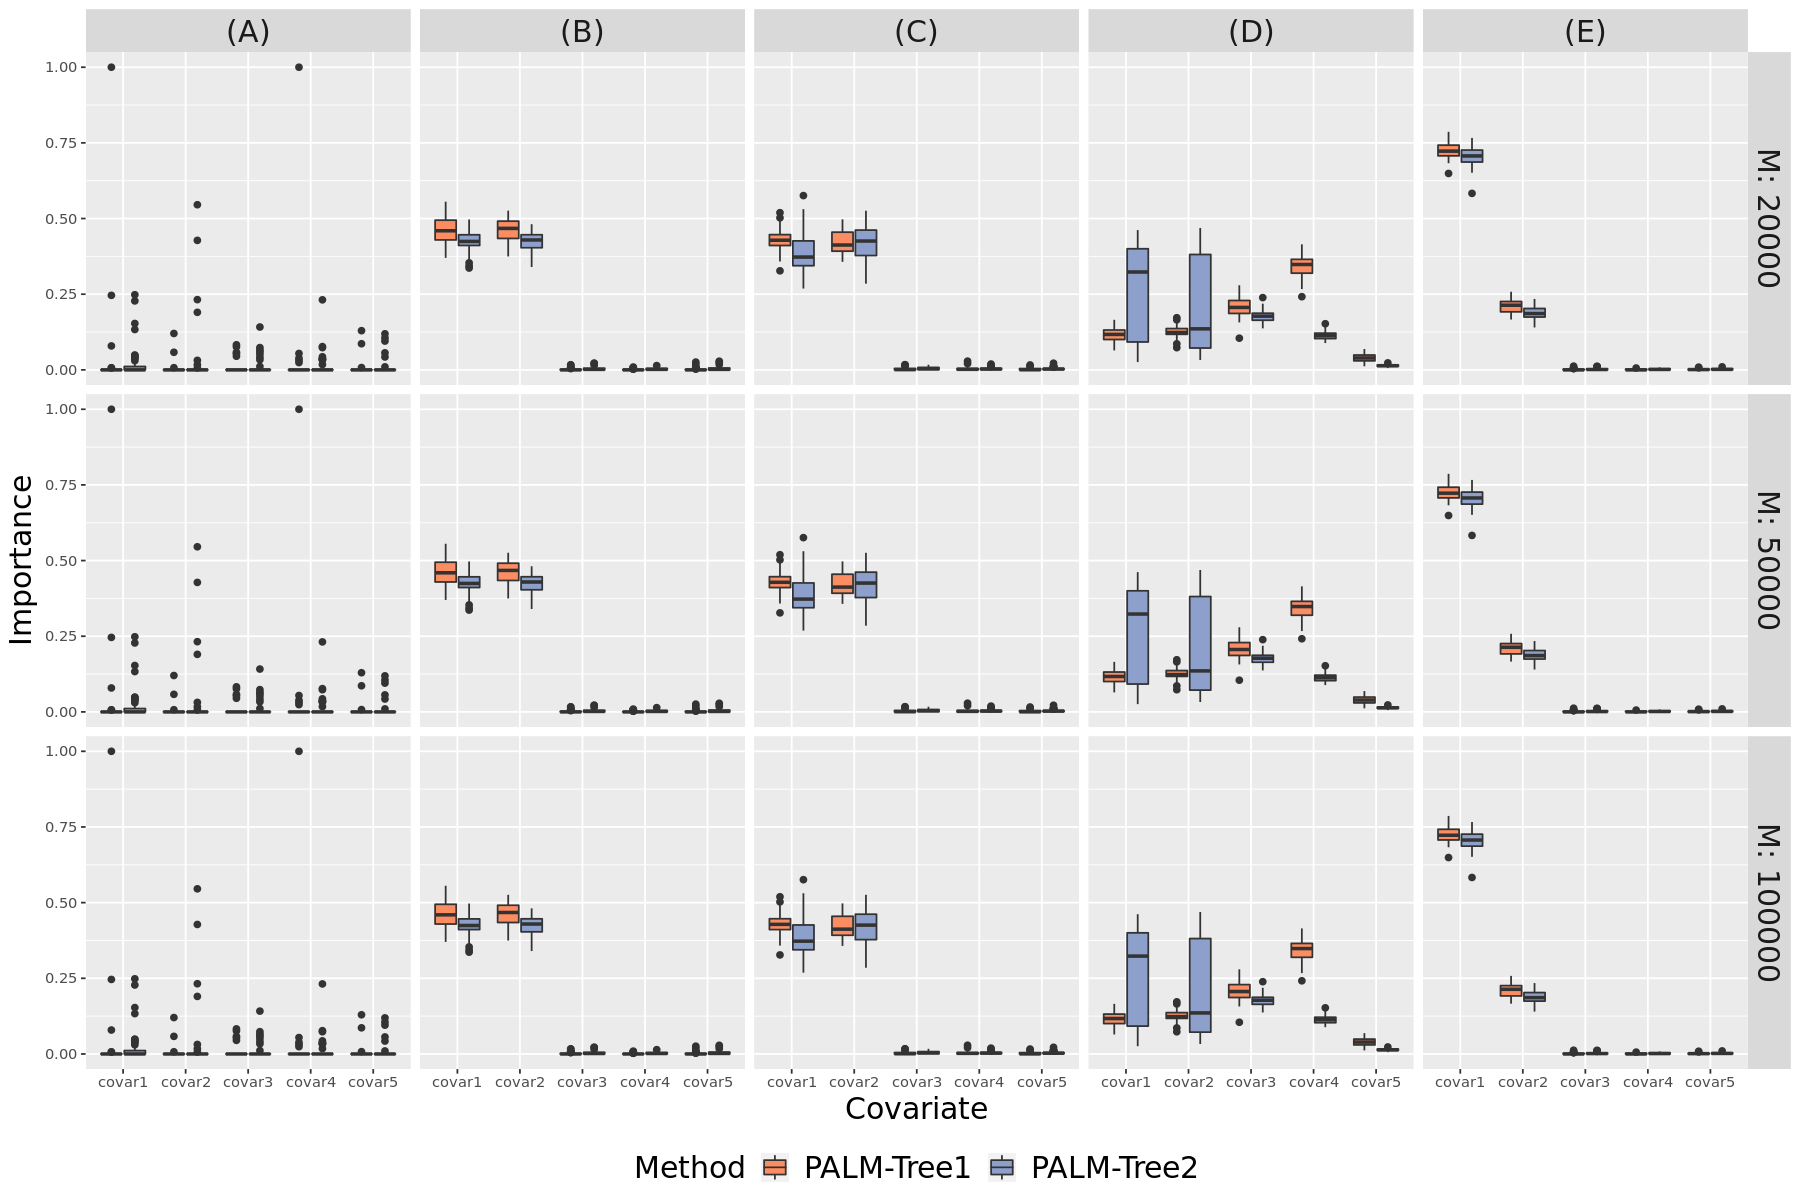

In [8]:
method = 'xgb'
imp = fread(sprintf('/home/xyubl/Thesis/r-py/%s_first5_var_imp_D50.csv', method), sep='\t')
Ms = unique(imp$M)
Mlabs = setNames(paste('M:', Ms), Ms)
Mlabs = factor(Mlabs, levels=Mlabs, labels=Mlabs)
long <- imp %>% 
  pivot_longer(cols=paste0('covar', 1:5), names_to='covariate', values_to='importance') %>%
  mutate(method=ifelse(J==1, 'PALM-Tree1', 'PALM-Tree2'), Mlab=Mlabs[as.character(M)])
colors <- RColorBrewer::brewer.pal(8, "Set2")[2:3]
g = ggplot(data=long, aes(x=covariate, y=importance, fill=method))
plot_imp_grid(g)